In [58]:
import logging
import numpy  as np
import panel  as pn
import xarray as xr

from glob    import glob
from pathlib import Path

import hvplot.xarray

logging.basicConfig(level=logging.WARN)

from mlky import (
    Config,
    Section
)

from sudsaq.ml.explain import (
    Dataset, 
    Explanation
)
self = Section({})
self.run = '/Volumes/MLIA_active_data/data_SUDSAQ/models/bias/gattaca.v4.bias-median'

pn.extension('plotly', loading_spinner='dots', loading_color='#00aa41', template='bootstrap')
pn.param.ParamMethod.loading_indicator = True


In [59]:
def getAvailable():
    files = glob(f'{self.run}/**/**/test.explanation.nc')
    order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    self.avail = {
        'months': set(), 
        'years' : set()
    }
    for file in files:
        month, year = file.split('/')[-3:-1]
        self.avail.months.update([month])
        self.avail.years.update([year])
    self.avail.months = sorted(self.avail.months, key=lambda month: order.index(month))
    self.avail.years = sorted(list(self.avail.years), key=lambda year: int(year))

getAvailable()

Column(sizing_mode='stretch_width')
    [0] Row(sizing_mode='stretch_width')
        [0] Markdown(str, width=200)
        [1] Button(button_type='primary', name='All', width=16)
        [2] Button(button_type='danger', name='None', width=32)
        [3] CheckButtonGroup(button_type='success', name='Select Months', options=['2011', '2012', ...], width=30)
    [1] Row(sizing_mode='stretch_width')
        [0] Markdown(str, width=200)
        [1] Button(button_type='primary', name='All', width=16)
        [2] Button(button_type='danger', name='None', width=32)
        [3] CheckButtonGroup(button_type='success', name='Select Years', options=['jan', 'feb', ...], width=30)
    [2] Row
        [0] Markdown(str)
        [1] GridSpec(height=200, ncols=3, nrows=4, sizing_mode='fixed', width=320)
            [0] FloatInput(end=90, height=50, name='Upper Latitude', start=-90, value=90, width=106)
            [1] FloatInput(end=180, height=50, name='Lower Longitude', start=-180, value=-180, width=106)
            [2] FloatInput(end=90, height=50, name='Lower Latitude', start=-90, value=-90, width=106)
            [3] FloatInput(end=180, height=50, name='Upper Longitude', start=-180, value=180, width=106)
            [4] Spacer(height=50, width=320)
    [3] Row
        [0] Button(name='Region')
        [1] Button(name='Waterfall')
    [4] ParamFunction(function, _pane=PNG, defer_load=False)
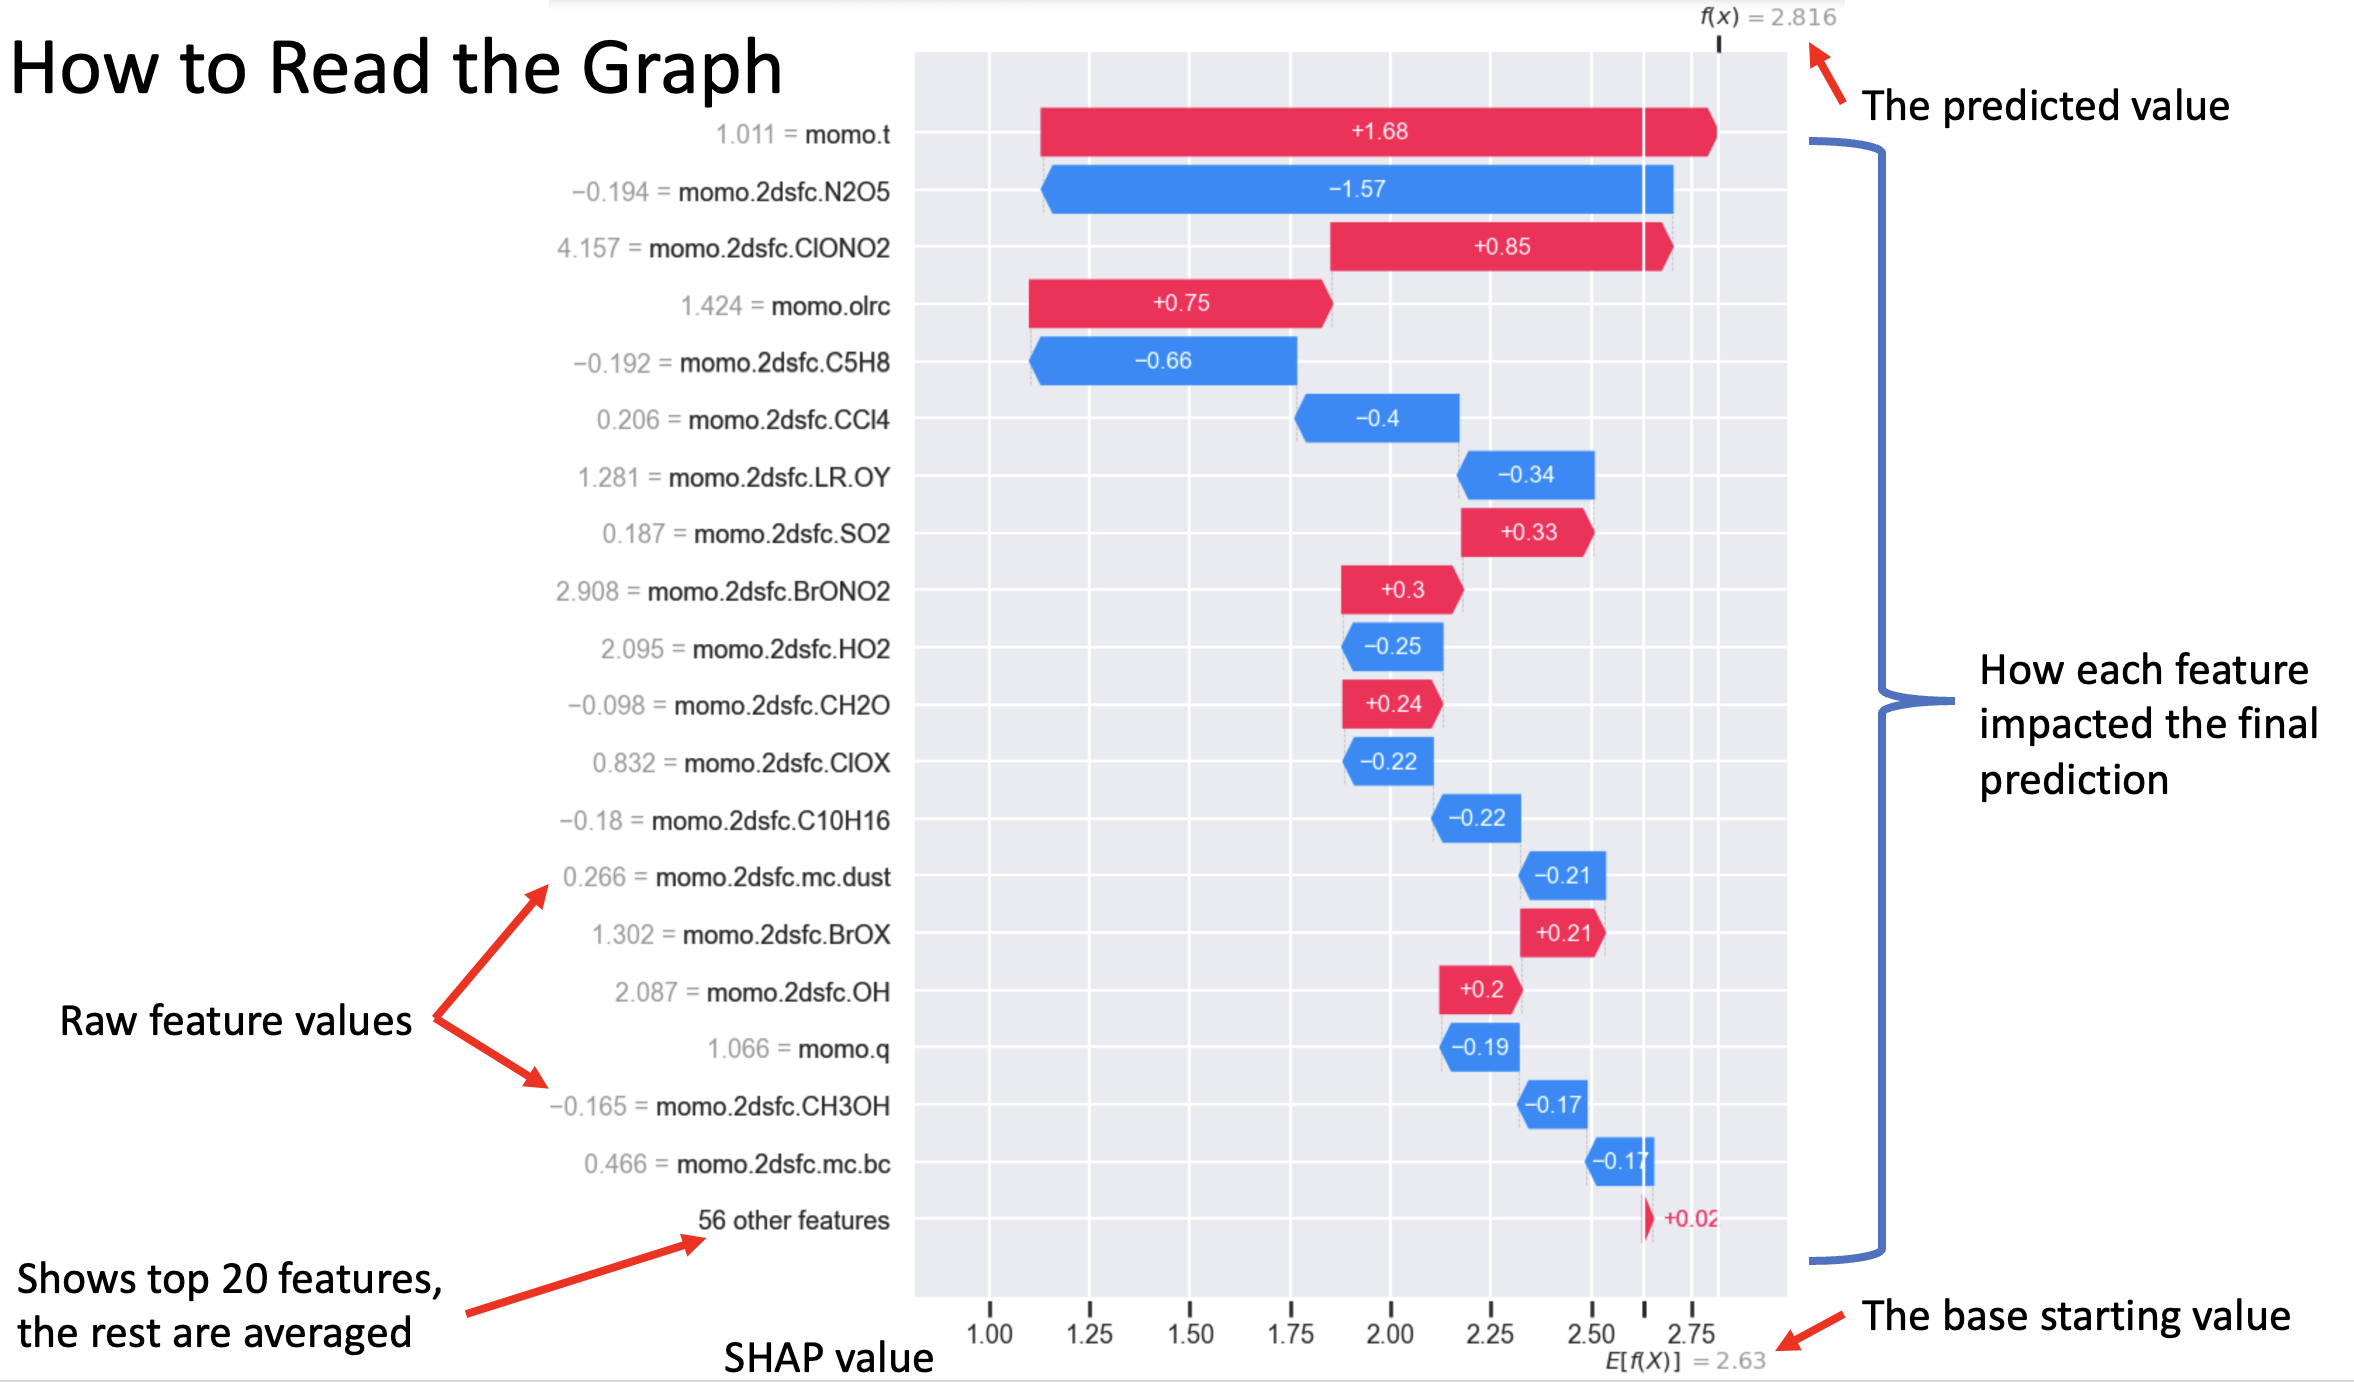

In [153]:
import time
import shap
import matplotlib.pyplot as plt
from functools import partial
from itertools import product


def btnList(func, name, options, lbl, lblw=100, **kwargs):
    def group_select(*_, group, values=None):
        group.set_param('value', group.values if values is None else values)
    
    def select(selected):
        self.months = selected

    group = pn.widgets.CheckButtonGroup(name=name, options=options, **kwargs)
    pn.bind(func, group, watch=True)

    all = pn.widgets.Button(
        width       = 16,
        name        = 'All', 
        button_type = 'primary'
    )
    pn.bind(partial(group_select, group=group), all, watch=True)
    none = pn.widgets.Button(
        width       = 32,
        name        = 'None', 
        button_type = 'danger'
    )
    pn.bind(partial(group_select, group=group, values=[]), none, watch=True)

    lbl = pn.pane.Markdown(lbl, width=lblw)

    return pn.Row(lbl, all, none, group, sizing_mode='stretch_width')


def plotWaterfall(key):
    """
    """
    loadRegion()
    plt.close('all')
    
    data = self[key].to_explanation(auto=True).mean(0)
    plot = shap.plots.waterfall(data, max_display=20, show=False)
    plt.tight_layout()
    pane = pn.pane.Matplotlib(plot)
    
    return pane

def generator():
    def click(event):
        if event:
            return self.generate()
        return self.default

    btn = pn.widgets.Button(
        name        = 'Generate', 
        button_type = 'primary'
    )
    btn.click = lambda: btn.param.set_param('value', True) # Simulates a click event
    bind = pn.bind(click, btn)
    plot = pn.param.ParamFunction(bind, loading_indicator=True)

    # column = pn.Column(btn, plot, sizing_mode='stretch_width')

    return btn, plot

def regionSel():
    """
    """
    def sel(value, dim, boundary):
        self[dim][boundary] = value

    # Populate defaults
    self['lat'] = {'upper': 90, 'lower': -90}
    self['lon'] = {'upper': 180, 'lower': -180}

    # Initialize the grid and label
    lbl  = pn.pane.Markdown('## Select region boundaries: ')
    
    grid = pn.GridSpec(sizing_mode='scale_width', height=100)
    grid = pn.GridSpec(width=320, height=200)

    # Upper Lat
    grid[0, 1] = widget = pn.widgets.FloatInput(name='Upper Latitude', value=self.lat.upper, step=1e-1, start=self.lat.lower, end=self.lat.upper)
    bind = pn.bind(sel, widget, dim='lat', boundary='upper', watch=True)

    # Lower Lon
    grid[1, 0] = widget = pn.widgets.FloatInput(name='Lower Longitude', value=self.lon.lower, step=1e-1, start=self.lon.lower, end=self.lon.upper)
    bind = pn.bind(sel, widget, dim='lon', boundary='lower', watch=True)

    # Lower Lat
    grid[2, 1] = widget = pn.widgets.FloatInput(name='Lower Latitude', value=self.lat.lower, step=1e-1, start=self.lat.lower, end=self.lat.upper)
    bind = pn.bind(sel, widget, dim='lat', boundary='lower', watch=True)

    # Upper Lon
    grid[1, 2] = widget = pn.widgets.FloatInput(name='Upper Longitude', value=self.lon.upper, step=1e-1, start=self.lon.lower, end=self.lon.upper)
    bind = pn.bind(sel, widget, dim='lon', boundary='upper', watch=True)

    # Extra invisible spacer helps with, well, spacing
    grid[3, :] = pn.Spacer()
    
    return pn.Row(lbl, grid)

months = btnList(
    name        = 'Select Months',
    options     = self.avail.years,
    button_type = 'success',
    width       = 30,
    lbl  = '## Select years(s):',
    lblw = 200,
    func = lambda selected: setattr(self, 'years', selected)
)
years = btnList(
    name        = 'Select Years',
    options     = self.avail.months,
    button_type = 'success',
    width       = 30,
    lbl  = '## Select month(s):',
    lblw = 200,
    func = lambda selected: setattr(self, 'months', selected)
)
self.default = pn.pane.PNG('/Users/jamesmo/Documents/screenshots/Screenshot 2023-09-19 at 2.19.39 PM.png', sizing_mode='scale_width')

# gbtn is the generator button, components 
gbtn, plot = generator()


def genButtons(generator):
    def genRegion(event):
        if event:
            self.generate = plotRegion
            generator.click()

    def genWaterfall(event):
        if event:
            self.generate = partial(plotWaterfall, key='region')
            generator.click()

    buttons = []

    btn = pn.widgets.Button(name='Region')
    pn.bind(genRegion, btn, watch=True)
    buttons.append(btn)

    btn = pn.widgets.Button(name='Waterfall')
    pn.bind(genWaterfall, btn, watch=True)
    buttons.append(btn)
    
    return pn.Row(*buttons)

genButts = genButtons(gbtn)

pn.Column(months, years, regionSel(), genButts, plot, sizing_mode='stretch_width')

In [139]:
def loadByFiles():
    if not hasattr(loadByFiles, 'cache'):
        loadByFiles.cache = {}
        
    files  = []
    combos = list(product(self.months, self.years))

    key = str(combos)
    if key in loadByFiles.cache:
        return loadByFiles.cache[key]
    
    for month, year in combos:
        files += glob(f'{self.run}/{month.lower()}/{year}/test.explanation.nc')

    if not files:
        print(f'No files found for combinations: {combos}')
        return

    self.ds = xr.open_mfdataset(files, mode='r', lock=False)
    self.ds = Dataset(self.ds)

    loadByFiles.cache[key] = self.ds

def checkBounds():
    """
    """
    if self.lat.upper <= self.lat.lower:
        print('Upper bound latitude must be less than the lower bound')
    
    if self.lon.upper <= self.lon.lower:
        print('Upper bound longitude must be less than the lower bound')

def cache(key):
    """
    WIP
    """
    def decorator(func):
        def execute(*args, **kwargs):
            cache[key] = func(*args, **kwargs)
            return cache[key]
        return execute
    
    cache = {}
    key   = Config.replace(key)

    if key in cache:
        return cache[key]
    return decorator


@cache(key=('((${.lat.lower}, ${.lat.upper}), (${.lon.lower}, ${.lon.upper}))'))
def loadRegion():
    """
    """
    checkBounds()
    loadByFiles()
    
    self.region = (self.ds
        .sel(lat=slice(self.lat.lower, self.lat.upper))
        .sel(lon=slice(self.lon.lower, self.lon.upper))
    ).load()

def plotRegion():
    """
    """
    checkBounds()
    loadByFiles()

    lats = (self.lat.lower <= self.ds.lat) & (self.ds.lat <= self.lat.upper)
    lons = (self.lon.lower <= self.ds.lon) & (self.ds.lon <= self.lon.upper)
    mask = lats * lons
    plot = mask.hvplot.quadmesh('lon', 'lat', global_extent=True, coastline=True)

    return pn.panel(plot)


Matplotlib(Figure)
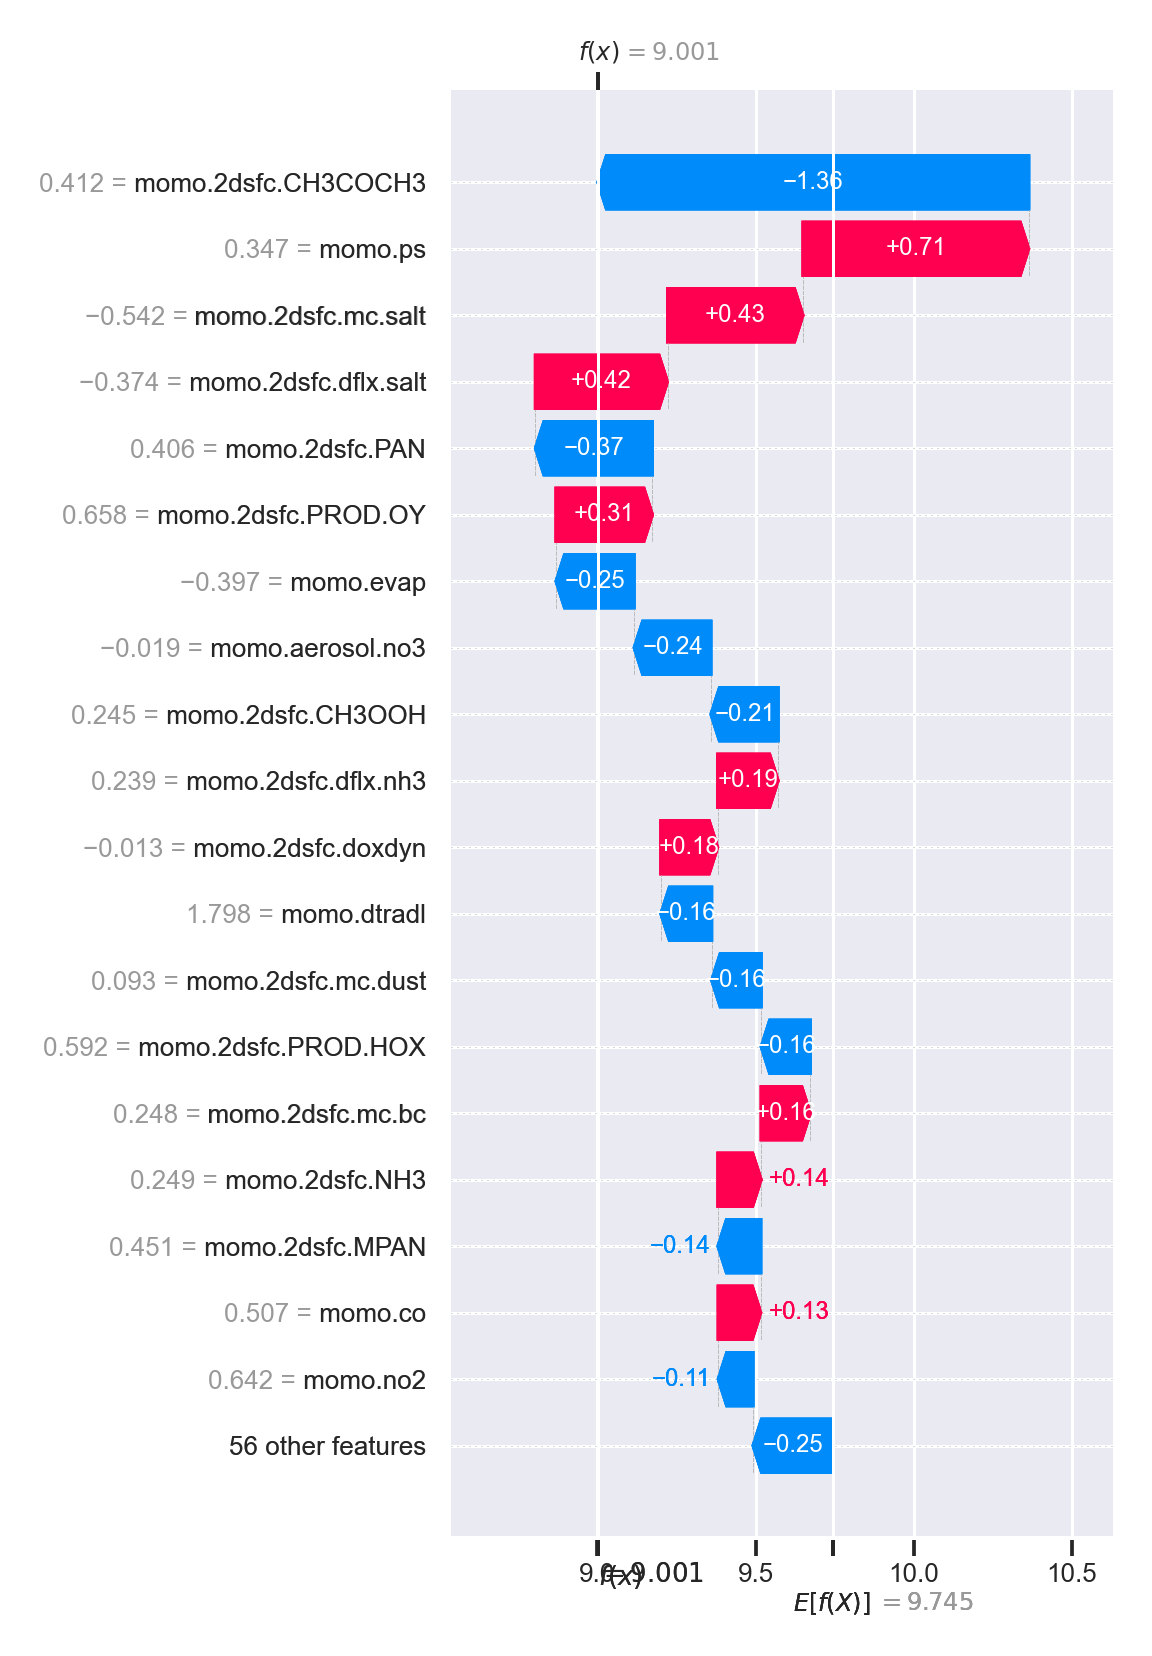

In [158]:
self.generated

In [54]:
self.region.to_explanation(auto=True).mean(0)

HoloViews(Overlay, sizing_mode='fixed')

<function shap.plots._waterfall.waterfall(shap_values, max_display=10, show=True)>

In [110]:
from mlky import Null

In [125]:
loadRegion()

In [4]:
%matplotlib inline

def draw(data, ax=None, figsize=(13, 7), title=None, coastlines=True, gridlines=True, **kwargs):
    """
    Portable geospatial plotting function
    """
    if ax is None:
        if 'plt' not in globals():
            global plt
            import matplotlib.pyplot as plt
        if 'ccrs' not in globals():
            global ccrs
            import cartopy.crs as ccrs

        fig = plt.figure(figsize=figsize)
        ax  = plt.subplot(111, projection=ccrs.PlateCarree())

    plot = data.plot.pcolormesh(x='lon', y='lat', ax=ax, **kwargs)

    if title:
        ax.set_title(title)
    if coastlines:
        ax.coastlines()
    if gridlines:
        ax.gridlines(draw_labels=False, color='dimgray', linewidth=0.5)

    return ax

In [ ]:
self.file = '/Users/jamesmo/projects/suds-air-quality/.local/data/shap/v4/jul/2015/test.explanation.nc'
self.outp = '/Users/jamesmo/projects/suds-air-quality/research/james/local'
self.log = logging.getLogger('UI')

self

In [104]:


loadByFiles()

In [6]:
self.ds

<xarray.Dataset>
Dimensions:      (lat: 160, lon: 320, time: 31, variable: 75)
Coordinates:
  * lat          (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon          (lon) float64 -178.9 -177.8 -176.6 -175.5 ... 177.8 178.9 180.0
  * time         (time) datetime64[ns] 2012-08-01 2012-08-02 ... 2012-08-31
  * variable     (variable) object 'momo.2dsfc.BrONO2' ... 'momo.no2'
Data variables:
    values       (variable, lat, lon, time) float64 dask.array<chunksize=(75, 160, 320, 31), meta=np.ndarray>
    data         (variable, lat, lon, time) float32 dask.array<chunksize=(75, 160, 320, 31), meta=np.ndarray>
    base_values  (lat, lon, time) float64 dask.array<chunksize=(160, 320, 31), meta=np.ndarray>

In [ ]:
def load(file):
    """
    """
    self.log.info(f'Loading file: {file}')
    try:
        self.ds = Dataset(xr.open_dataset(file).load())
        ns = self.ds.stack(loc=['lat', 'lon', 'time']).transpose()
        self.ex = ns.to_explanation()
        self.file = file
    except:
        self.log.exception(f'Failed to load file: {file}')
    self.log.debug('Finished load()')

load(self.file)
self.ex

In [ ]:
def preload_summaries():
    pass

self.outp = Path(self.outp).resolve()
self.outp.mkdir(parents=True, exist_ok=True)



In [ ]:
self.outp.exists()

In [ ]:
self.mds = self.ds.mean('time')

In [ ]:
import cartopy.crs       as ccrs
import matplotlib.pyplot as plt
import shap

%matplotlib inline

from tqdm import tqdm


def geospatial(variable, save=None, **params):
    """
    """
    fig = plt.figure(figsize=(20, 10))
    ax = plt.subplot(111, projection=ccrs.PlateCarree())

    # Mean along time axis
    self.mds['values'].sel(variable=variable).plot.pcolormesh(x='lon', y='lat', ax=ax, **params)
    
    ax.set_title(f'Mean SHAP Values for {variable}')
    ax.coastlines()
    ax.gridlines(draw_labels=['bottom', 'left'], color='dimgray', linewidth=0.5)

    # Save and flush
    plt.tight_layout()
    if save:
        plt.savefig(save)
    plt.close('all') # flush

def bar(save=None, **params):
    """
    """
    # SHAP built-in plotter
    shap.plots.bar(self.ex, show=False, **params)

    # Show=False enables plot editting
    plt.title('Mean Absolute SHAP Value')

    # Save and flush
    plt.tight_layout()
    if save:
        plt.savefig(save)
    plt.close('all') # flush

def summary(save=None, **params):
    """
    """
    # SHAP built-in plotter
    shap.summary_plot(self.ex, show=False, **params)

    # Show=False enables plot editting
    
    # Save and flush
    plt.tight_layout()
    if save:
        plt.savefig(save)
    plt.close('all') # flush


plotters = {
    'bar': bar,
    'summary': summary,
    'geospatial': geospatial
}

def preload():
    for key, params in config.preload.items():
        params = list(parameterize(params))
        for parms in tqdm(params, desc=f'Generating {key} plots'):
            file = self.outp/f'{key}.{create_name(parms)}.png'
            if not file.exists():
                plotters[key](save=file, **parms)

preload()

In [ ]:
config = Config("""
preload:
    bar:
        max_display: [null, 10, 20]
    summary:
        max_display: [null, 10]
    geospatial:
        variable: [momo.co, momo.ps, momo.t, momo.no2]
        cmap: viridis
        levels: 20
""")

In [ ]:
self.ds.variable

In [ ]:
from mlky import Section as S

def parameterize(params, skip=[]):
    """
    Generates the total combination of parameters from a dict of 
        {param1: [opt1, opt2, ...], param2: [opt1, ...], ...}
    to 
        [{param1: option[i], param2: option[i], ...}, ...]
    Parameters that are not lists will be carried forward as-is to all combinations
    """
    # Find an unprocessed key
    for key in params:
        if key not in skip:
            break
    else:
        # All keys processed
        return {}

    # Gather the other keys
    others = list(parse(params, skip + [key]))
    value  = params[key]

    # Yield a combination of parameters
    if isinstance(value, list):
        for val in value:
            if others:
                for other in others:
                    yield S({key: val}) + other
            else:
                yield S({key: val})
    else:
        if others:
            for other in others:
                yield S({key: value}) + other
        else:
            yield S({key: value})

# Simple function to create a name from the parameters
create_name = lambda params: '.'.join([f'{k}={v}' for k, v in params.items()])

In [ ]:
params = list(parameterize(c.bar))[0]

In [ ]:
def create_name(params):
    for key, val in params.items():
        